In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
#python version 3.8.10
'''fancyimpute==0.7.0
imblearn==0.0
joblib==1.3.1
matplotlib==3.7.2
numpy==1.24.4
pandas==1.3.5
scikit_learn==1.3.0
scipy==1.10.1
seaborn==0.12.2
six==1.16.0
xgboost==1.7.6'''

'fancyimpute==0.7.0\nimblearn==0.0\njoblib==1.3.1\nmatplotlib==3.7.2\nnumpy==1.24.4\npandas==1.3.5\nscikit_learn==1.3.0\nscipy==1.10.1\nseaborn==0.12.2\nsix==1.16.0\nxgboost==1.7.6'

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
from fancyimpute import KNN, SoftImpute

(CVXPY) Sep 04 05:12:02 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('dlopen(//anaconda3/envs/nlp_course/lib/python3.7/site-packages/cvxopt/base.cpython-37m-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: //anaconda3/envs/nlp_course/lib/python3.7/site-packages/cvxopt/.dylibs/libgomp.1.dylib (which was built for Mac OS X 11.3)\n  Expected in: /usr/lib/libSystem.B.dylib\n in //anaconda3/envs/nlp_course/lib/python3.7/site-packages/cvxopt/.dylibs/libgomp.1.dylib')
(CVXPY) Sep 04 05:12:02 PM: Encountered unexpected exception importing solver GLPK:
ImportError('dlopen(//anaconda3/envs/nlp_course/lib/python3.7/site-packages/cvxopt/base.cpython-37m-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: //anaconda3/envs/nlp_course/lib/python3.7/site-packages/cvxopt/.dylibs/libgomp.1.dylib (which was built for Mac OS X 11.3)\n  Expected in: /usr/lib/libSystem.B.dylib\n in //anaconda3/envs/nlp_course/lib/python3.7/site-packages/cvxopt/

# Loan or not to Loan

### In this porject, I am going to build models to make decision of approval/rejection of loan. This data set consist of Million loan record with features about the each customer and wheather the loan is returned or not. It is important to determine to build a model to decide to giving loan, because too generous loan criteria will end up risk in business and if the criteria is too tight, loaning will not make money from the business. Also, determining criteria should accruately predicte future behaivor of customers.


### 1. Environment setup. 
#### To Start with the project, I will install all the packages needed. If you are following this project, please gather all the "import" part in front of any other codes.

In [9]:

from fancyimpute import KNN, SoftImpute
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
import operator
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing
from imblearn.over_sampling import SMOTE
%matplotlib inline
import operator
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing
from imblearn.over_sampling import SMOTE

In [10]:
import operator

In [11]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [12]:
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [13]:
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

### 2. functions will be used in the later part of project.

In [15]:

def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    #Predicting the probabilities of the Tet data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    #Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))
    
    return est, y1, y2[:, 1]


#Function to find which features are more important than others through model
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(df_LC.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_x

#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

### 3. Data importing, EDA and data cleaning.
#### In this section, I will import the data first. Secondly, I will check basic info of the data with explorelatory data analysis. And then, will clean the data to be prepared for predictive modeling.

In [16]:
# Import data set from LoansTrainingSetV2.csv, reccomend to put the csv file in the same location of jupyter notebook file.
data =pd.read_csv("LoansTrainingSetV2.csv")

In [23]:
data.head(10)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0
5,7e9f6759-6a13-48ef-adfa-ef9fbcfcfcc8,05301ee5-29ec-48b6-b3e5-0813ea25d684,Loan Refused,11911,Short Term,7420.0,2 years,Home Mortgage,70475.0,other,886.81,17.7,NaN,13,0,28212,59897,0.0,0.0
6,c2b0aa3e-555b-441b-a4aa-e0e4a52c87d3,db3e74ec-2123-4608-be8d-a93e98cabfcf,Loan Refused,28988,Short Term,7420.0,3 years,Home Mortgage,58074.0,Debt Consolidation,871.11,22.8,NaN,9,0,14423,54018,0.0,0.0
7,233e0119-6dfe-47c0-a212-b4cc00371c8d,def66e46-951e-4bff-bf96-87ae6e092e19,Loan Refused,17705,Long Term,6630.0,3 years,Own Home,49180.0,Debt Consolidation,274.59,30.2,NaN,10,1,4252,25012,1.0,0.0
8,fc9d109b-15c2-4fe3-b7d8-27610b89f80b,f54c53e4-acd7-4e29-8f55-d2a247a4b62a,Loan Refused,16812,Short Term,7360.0,7 years,Rent,50945.0,Debt Consolidation,590.12,14.6,NaN,9,0,12903,15379,0.0,0.0
9,35ee60ed-df2d-4d3a-98ba-03d944d65c74,93cbb4b9-4e88-4b93-8beb-a2a00d415cd5,Loan Refused,9796,Long Term,6720.0,< 1 year,Rent,58776.0,Debt Consolidation,666.13,9.4,17.0,12,0,4939,15198,0.0,0.0


In [22]:

len(data)
#total lenght of 111107 data

111107

111107

In [17]:
# Delete duplicate load ID, each loan ID should be appeared only once in the dataset.
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)
len(data)

88910

#### As the target variable for the modeling will be "Loan Status", we have to look into this feature. Since this feature is binary, the modeling problem will be a classification. 

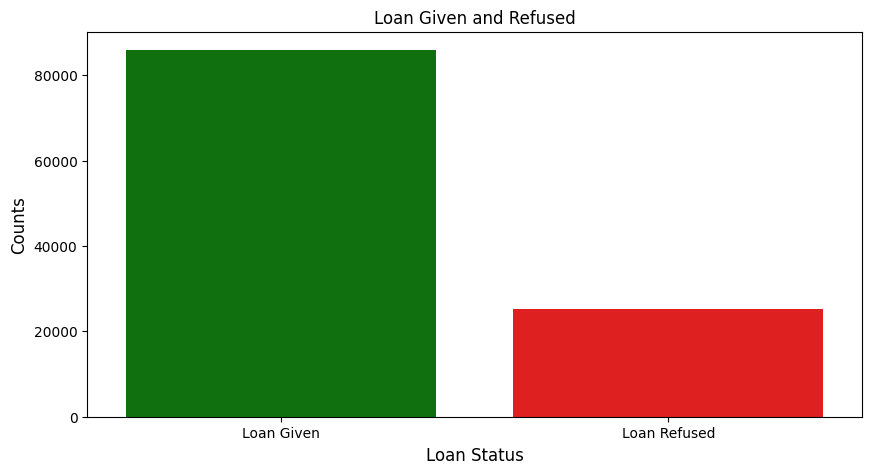

In [25]:
##########PLotting the loan status and check the balance. 
status=data["Loan Status"].value_counts() 
plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, palette=['green','red'])
plt.title('Loan Given and Refused')
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()

In [27]:
status

Loan Given      85934
Loan Refused    25173
Name: Loan Status, dtype: int64

#### About 77% approaval rate for loan status. It is imbalanced, but it is not that severe.

#### Let's checkup other variables are looking fine to use it as a predictor in the models. 

In [28]:
###Check Current Loan ammount variable.
data["Current Loan Amount"].describe()

count    1.111070e+05
mean     1.147718e+07
std      3.185508e+07
min      4.910000e+02
25%      8.162000e+03
50%      1.418300e+04
75%      2.382200e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

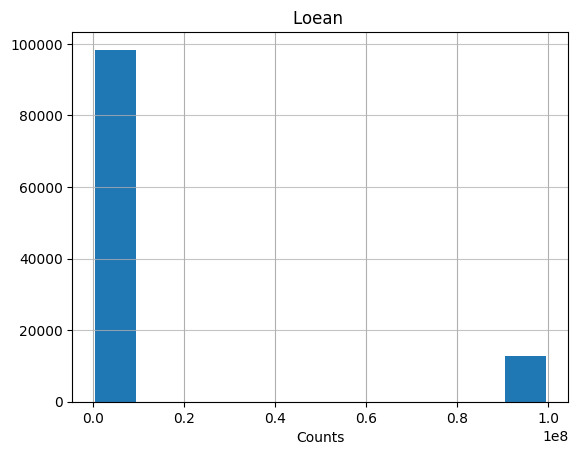

In [32]:
### plotting distrubtion of this feature.
data["Current Loan Amount"].plot.hist(grid=True, rwidth=0.9)
plt.title('Loean ')
plt.xlabel('Counts')
plt.ylabel('')
plt.grid(axis='y', alpha=0.75)


#### The histogram does not show much information to us due to the outier values that are deviated from the most of the loan amounts.

In [33]:

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

15660.0


In [34]:
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]


5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [35]:
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()

count    98369.000000
mean     14182.062144
std       8459.992025
min        491.000000
25%       7830.000000
50%      12145.000000
75%      19660.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64

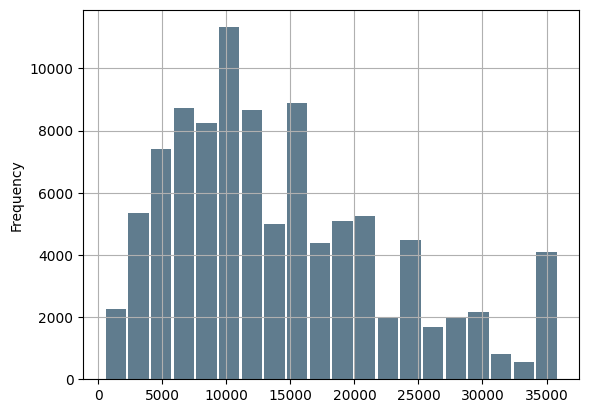

In [36]:
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
temp.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
                   
temp.describe()

#### After removing outliers the histogram looks well distributed

In [25]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

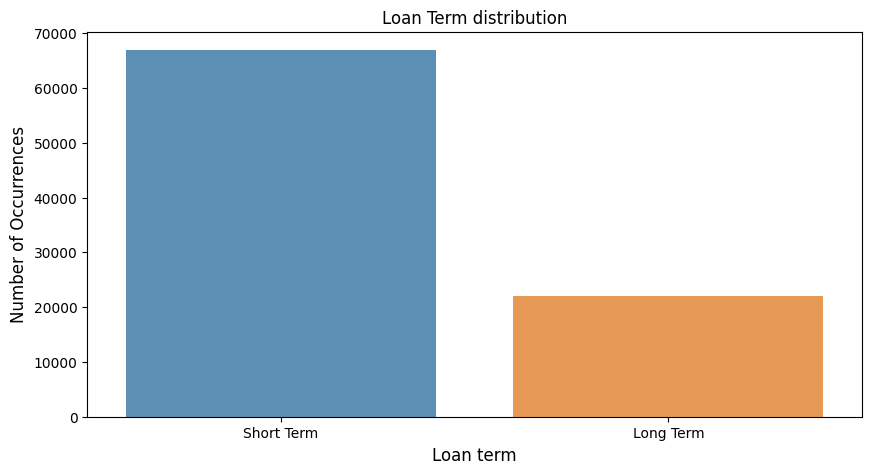

In [26]:

############Term ##############

status=data["Term"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()


In [37]:
#####Credit Score#############

##Max is 7510. It should be between 0-800

data["Credit Score"].describe()

count    89769.000000
mean      1075.795029
std       1474.133505
min        585.000000
25%        705.000000
50%        724.000000
75%        741.000000
max       7510.000000
Name: Credit Score, dtype: float64

<AxesSubplot:xlabel='Credit Score'>

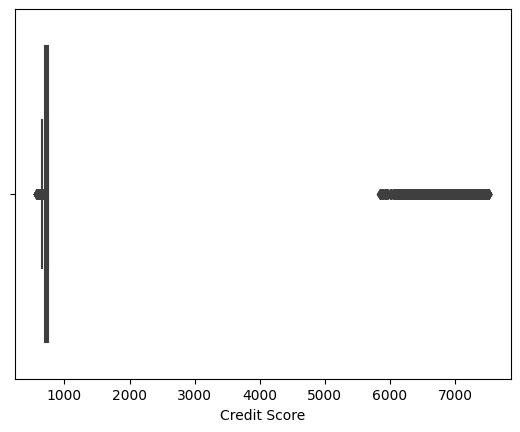

In [38]:

sns.boxplot(x=data["Credit Score"])

In [29]:
data["Credit Score"].isnull().unique()

array([False,  True])

In [30]:
data["Credit Score"].isnull().sum()

21338

In [31]:
#Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10

data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])


<AxesSubplot:xlabel='Credit Score_1', ylabel='Density'>

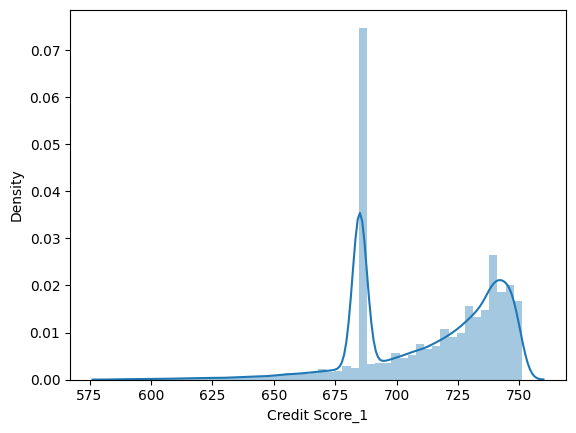

In [32]:
#Now lets replace the missing values with median 
median_score=statistics.median(data["Credit Score"])

data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

sns.distplot(data["Credit Score_1"])


<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

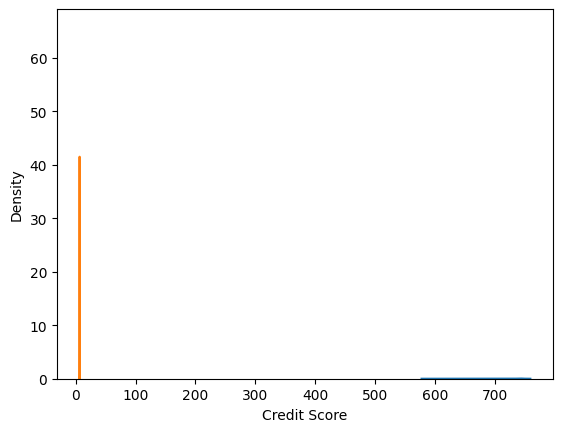

In [33]:
#As we can see this data is skewed so when we replace it with median it is giving us problems. 
#Replacing with 75th percentile and taking log we get a better distribution


data["Credit Score"].fillna(741, inplace = True) 

sns.distplot(data["Credit Score"])
sns.distplot(np.log(data["Credit Score"]))

In [34]:
data['Home Ownership'].unique()
#As we can see it has Home Mortgage and haveMortgage as 2 different classes. Lets fix that


array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [35]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

data['Home Ownership'].unique()


array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [36]:
##################Annual Income######################
data['Annual Income'].describe()


count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [37]:
##Lets look at the quantiles of this columns

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [38]:
#As we can see they lie in the 99th percentile of the data.Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287


data['Annual Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end

21338

In [39]:


###############Loan Purpose ###############

data['Purpose'].value_counts()
#So other and Other mean the same thing. Lets make it the same

Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [40]:
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

In [41]:
#######Monthly debt ###############


data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore


count     88910
unique    76609
top           0
freq         55
Name: Monthly Debt, dtype: object

In [42]:
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float


0         777.39
1         892.09
2        1244.02
3         990.94
4         503.71
          ...   
88905     567.62
88906    2508.63
88907      818.2
88908     360.17
88909     749.13
Name: Monthly Debt, Length: 88910, dtype: object

In [43]:
data['Monthly Debt'].unique()

array(['777.39', '892.09', '1244.02', ..., 2508.63, 818.2, 360.17],
      dtype=object)

In [44]:
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '')


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

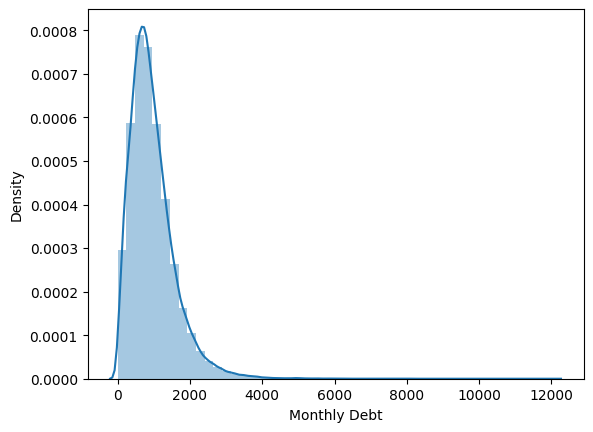

In [45]:
data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

sns.distplot(data["Monthly Debt"])

In [46]:
#We can see that there are outliers in this data because of the plot
#Lets explore

data['Monthly Debt'].describe()
#The max value is too high here


count    65536.000000
mean       962.406632
std        632.799593
min          0.000000
25%        532.250000
50%        843.770000
75%       1251.342500
max      12055.680000
Name: Monthly Debt, dtype: float64

In [47]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     464.21000
0.750    1251.34250
0.900    1740.35000
0.950    2112.21000
0.990    3084.08600
0.999    4927.21625
Name: Monthly Debt, dtype: float64

In [48]:
#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile

0.9995    5513.352425
0.9999    7719.187600
Name: Monthly Debt, dtype: float64

In [49]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330

0.99970     5979.063765
0.99999    11253.511940
Name: Monthly Debt, dtype: float64

In [50]:
data['Monthly Debt'].quantile([0.999,1])


0.999     4927.21625
1.000    12055.68000
Name: Monthly Debt, dtype: float64

<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

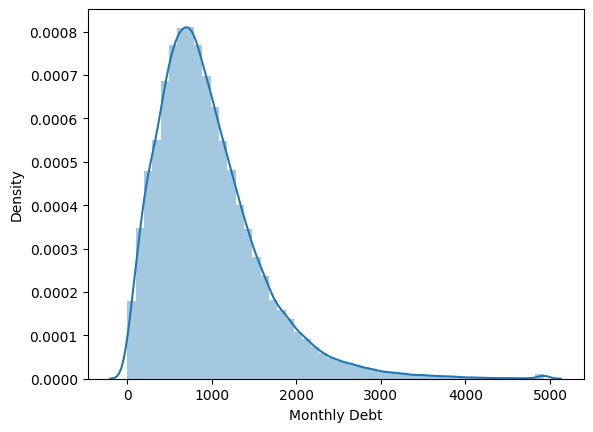

In [51]:
#Need to replace this
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.distplot(data["Monthly Debt"])
#Now we get the right distribution

<AxesSubplot:xlabel='Years of Credit History', ylabel='Density'>

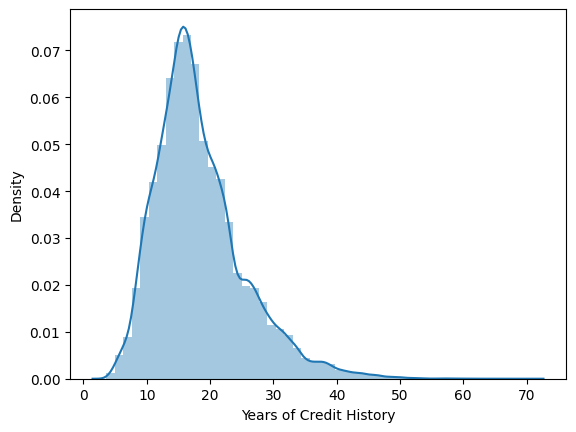

In [52]:
####################Years of credit history #################

data['Years of Credit History'].value_counts()


sns.distplot(data["Years of Credit History"])
#Over all looks pretty clean! no need of doing anything


In [53]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()


count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [54]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values


0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

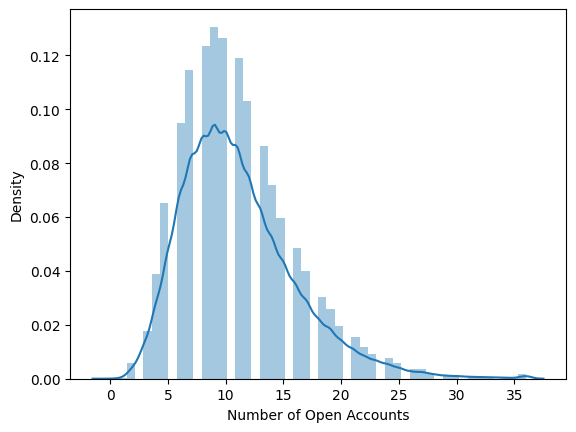

In [55]:
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36


sns.distplot(data['Number of Open Accounts'])
#Looks good now

<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Density'>

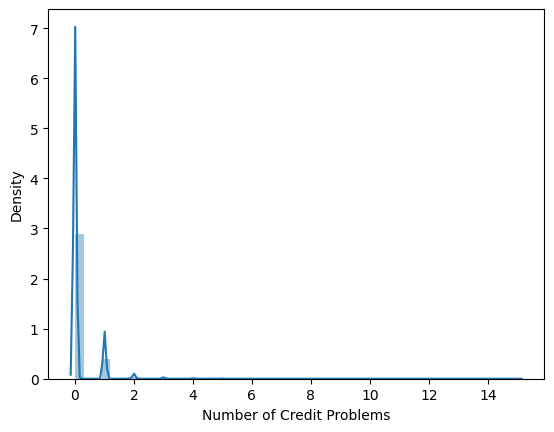

In [56]:
#######################Number of Credit problems##############

data['Number of Credit Problems'].describe() 
#Max looks a bit higher. Lets see

sns.distplot(data['Number of Credit Problems'])


In [57]:
#Okay lets look at value _counts


data['Number of Credit Problems'].value_counts()

#Okay looks good


0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: Number of Credit Problems, dtype: int64

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

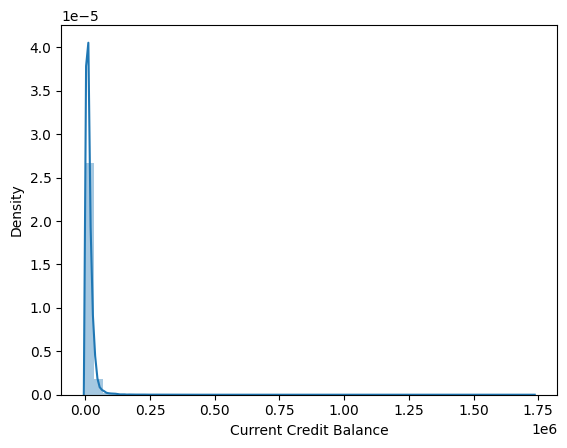

In [58]:
##################Current Credit Balance###########

data['Current Credit Balance'].describe()

sns.distplot(data['Current Credit Balance'])
#It seems there are outliers in this data. Lets investigate


In [59]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])


0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [60]:
#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

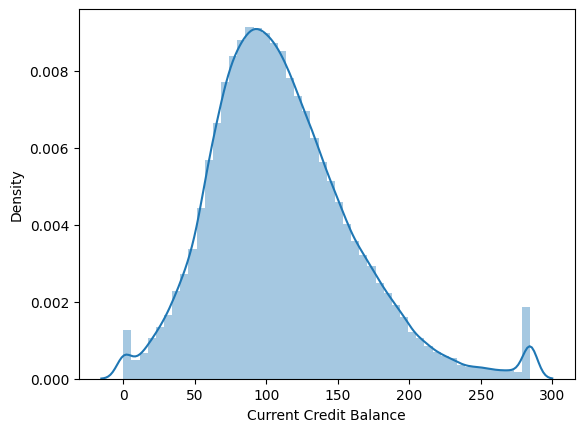

In [61]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007


sns.distplot(data['Current Credit Balance']**(1/2))
#The plot doesnt look good. We need to transform it


In [62]:
data['Current Credit Balance']=data['Current Credit Balance']**(1/2)


In [63]:
#######################Max open credit################

data['Maximum Open Credit'].describe()

count     88910
unique    58216
top           0
freq        450
Name: Maximum Open Credit, dtype: object

In [64]:
data['Maximum Open Credit'].value_counts()

0         450
0         160
15847       9
17464       9
6827        8
         ... 
28296       1
10199       1
132602      1
10395       1
21124       1
Name: Maximum Open Credit, Length: 58216, dtype: int64

In [65]:
#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)


In [66]:
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])

In [67]:
data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean  


2

In [68]:
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)


In [69]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])



0.55       24037.95
0.76       37259.84
0.87       50736.66
0.98      114682.56
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [70]:
#Lets replace the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423


In [71]:
###############Bankruptcies##########
data['Bankruptcies'].describe()


count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [72]:
data['Bankruptcies'].value_counts()


0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [73]:
data['Bankruptcies'].unique()

array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [74]:
data['Bankruptcies']=data['Bankruptcies'].fillna(3)


In [75]:
####Tax Liens######

data['Tax Liens'].describe()


count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [76]:
data['Tax Liens'].value_counts()


0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: Tax Liens, dtype: int64

In [77]:
data['Bankruptcies'].unique()

array([0., 1., 3., 2., 4., 5., 7., 6.])

In [78]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [79]:
#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)
#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23092221.868378
[SoftImpute] Iter 1: observed MAE=261.480152 rank=3
[SoftImpute] Iter 2: observed MAE=258.548469 rank=3
[SoftImpute] Iter 3: observed MAE=258.207662 rank=3
[SoftImpute] Iter 4: observed MAE=258.184852 rank=3
[SoftImpute] Iter 5: observed MAE=258.204643 rank=3
[SoftImpute] Iter 6: observed MAE=258.230069 rank=3
[SoftImpute] Iter 7: observed MAE=258.255573 rank=3
[SoftImpute] Iter 8: observed MAE=258.280106 rank=3
[SoftImpute] Iter 9: observed MAE=258.303449 rank=3
[SoftImpute] Iter 10: observed MAE=258.325504 rank=3
[SoftImpute] Iter 11: observed MAE=258.346214 rank=3
[SoftImpute] Iter 12: observed MAE=258.365509 rank=3
[SoftImpute] Iter 13: observed MAE=258.383517 rank=3
[SoftImpute] Iter 14: observed MAE=258.400220 rank=3
[SoftImpute] Iter 15: observed MAE=258.415645 rank=3
[SoftImpute] Iter 16: observed MAE=258.429899 rank=3
[SoftImpute] Iter 17: observed MAE=258.443135 rank=3
[SoftImpute] Iter 18: observed MAE=258.455321 ra

In [80]:
#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-0.1869176  -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958408]
 [ 1.48349848  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958408]
 [ 0.32079375 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958408]
 ...
 [ 1.40247376 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958408]
 [-1.1281112  -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958408]
 [ 0.62515919 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361205]]
   
(88910, 16)


In [81]:
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

Accuracy:  0.7276646796385858
Area under the ROC curve:  0.7437786337121257
F-metric:  0.38419803323160395
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     18981
           1       0.55      0.29      0.38      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:
[0.73088046 0.73762853 0.73150157 0.73150157 0.72740419]
[0.15770203 0.25137326 0.16299245 0.02831689 0.04490009 0.04055737
 0.03080421 0.03046158 0.02761248 0.02706706 0.02785725 0.02524857
 0.03073877 0.03578309 0.03659303 0.0419918 ]


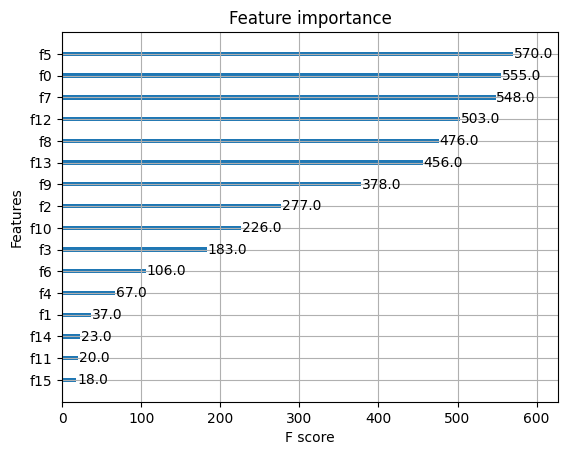

In [82]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)


In [83]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

Accuracy:  0.7290893412814456
Area under the ROC curve:  0.7381679994031858
F-metric:  0.3351122561648877
 
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     18981
           1       0.57      0.24      0.34      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.58      0.58     26673
weighted avg       0.70      0.73      0.69     26673

 
Evaluation by cross-validation:
[0.73666452 0.74116324 0.73608098 0.73664337 0.73013578]


In [84]:
#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6839500618603082
Area under the ROC curve:  0.6073078340129547
F-metric:  0.30992141453831046
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18981
           1       0.42      0.25      0.31      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.65      0.68      0.66     26673

 
Evaluation by cross-validation:
[0.69368573 0.69705977 0.69783884 0.69141159 0.68747489]


In [85]:
########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Accuracy:  0.7201289693697747
Area under the ROC curve:  0.6722709585903062
F-metric:  0.21213720316622697
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.65      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72606041 0.72919344 0.72812726 0.7282076  0.72684181]


In [86]:
########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6479586098301653
Area under the ROC curve:  0.576858233962676
F-metric:  0.40114795918367346
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     18981
           1       0.39      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.65      0.65      0.65     26673

 
Evaluation by cross-validation:
[0.6534383  0.65616967 0.65686511 0.65895396 0.65638306]


computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 
computing XGBClassifier - Non-balanced 


,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.244187,0.752926,0.574873,0.254380,0.352694,Non-balanced
1,LogisticRegression,0.158180,0.672405,0.554031,0.127651,0.207495,Non-balanced
2,RandomForestClassifier,0.195504,0.695749,0.510175,0.237782,0.324378,Non-balanced
3,XGBClassifier,0.245700,0.743843,0.547578,0.290344,0.379477,Non-balanced


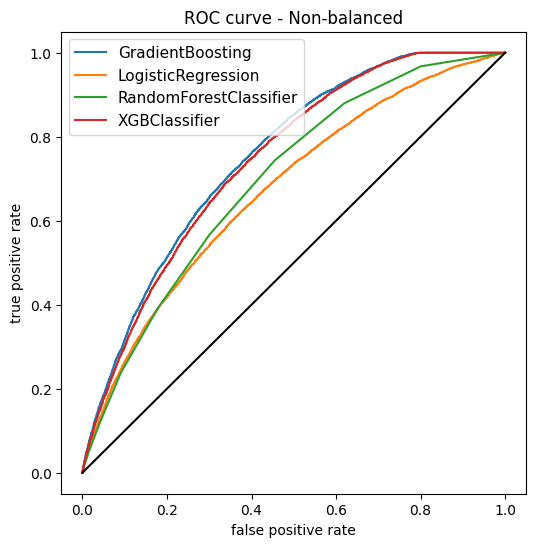

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
models_report

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 
computing XGBClassifier - Balanced 


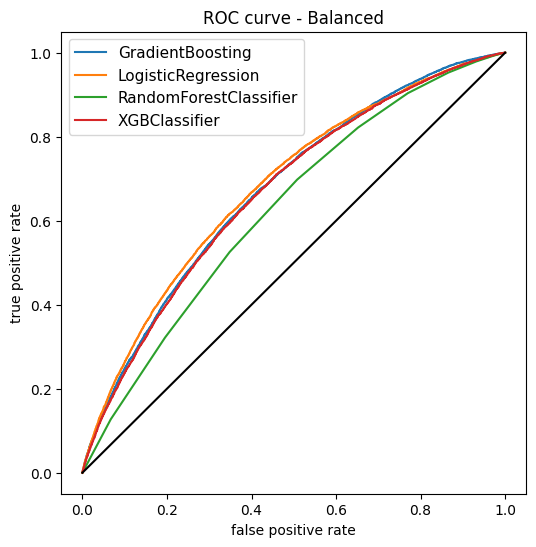

In [88]:
index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [89]:
################Now we  know that GBM model performed the best so 
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')

['GBM_Model_version1.pkl']